# Napovedovanje cen kripto valut, s pomočjo pogovorov na socialnih platformah

Podatkovno rudarjenje, projektna naloga, `18.5.2021`  
**`Nik Prinčič`**  
**`Jaka Škerjanc`**  
**`Erik Pahor`**


### Opis problema

Področje naše raziskave je trg kripto valut, bolj natančno kako pogovori na platformah kot sta Discord in Reddit, kjer si mnenja izmenjujeo predvsem kripto navdušenci, vplivajo na gibanje cen. Osredotočili se bomo predvsem na kriptovalute z nizko tržno kapitalizacijo (market cap).

Izbrane naloge, ki jih želimo raziskat:

* Ali lahko iz objav napovemo spremembo cene?
* Poiskati povezavo med ceno in popularnostjo na Reddit/Discord
* Ali kateri kovanci posebej izstopajo?
* Kako se je spreminajalo zanimanje za kripto valute?


### Pridobivanje podatkov

Podatke o objavah uporabnikov smo dobili na dveh platformah

* Discord: Tri skupnosti kripto navdušencev skupno preko 130.000 članov. Za obdobje od 1.2.2021 do 31.3.2021 smo pridobili skupno 1.700.000 sporočil. Ker Discord ne omogoča dostopa do sporočil preko kašnega vmesnika (npr. API), smo morali podatke pridobiti z programom [DiscordChatExporter](https://github.com/Tyrrrz/DiscordChatExporter), ki nam vrne .csv obliko. Da zmanjšamo velikost izbrišemo vse nepotrebne metapodatke. Na koncu nam ostane vsebina sporočila ter datum in čas.
* Reddit: Tukaj smo poiskali 4 "subreddite", kjer imajo vsak dan oziroma teden objavo v kateri uporabniki debatirajo o trenutno aktualnih zadevah. Pridobili smo komentarje iz 71 takih objav. Za to smo uporabili [PRAW: The Python Reddit API Wrapper](https://github.com/praw-dev/praw).


Primeri komentarjev ki smo jih pridobili.

In [29]:
import os
import pandas as pd
BASE_PATH = os.path.abspath(os.path.curdir)

data_discord = pd.read_csv(os.path.join(BASE_PATH, "data", "posts", "discord", "CryptoCurrencyFeb2021.csv"))
data_reddit = pd.read_csv(os.path.join(BASE_PATH, "data", "posts", "reddit", "CryptoMarkets", "weekly-discussion-megathread-march-14-2021-gmt0.csv"))

print("Discord")
print(data_discord[0:1], "\n")

print("Reddit")
print(data_reddit[0:1])

Discord
         date                                            content
0  1612134004  85% profit on GRT so far, looking good for .99... 

Reddit
         date                                 content  score
0  1615912537  ADA showing signs of upward divergence      4


Prikaz števila komentarjev od febuarja do konca marca.

0       1612134000
1       1612137600
2       1612141200
3       1612144800
4       1612148400
           ...    
1405    1617192000
1406    1617195600
1407    1617199200
1408    1617202800
1409    1617206400
Name: date, Length: 1410, dtype: int64


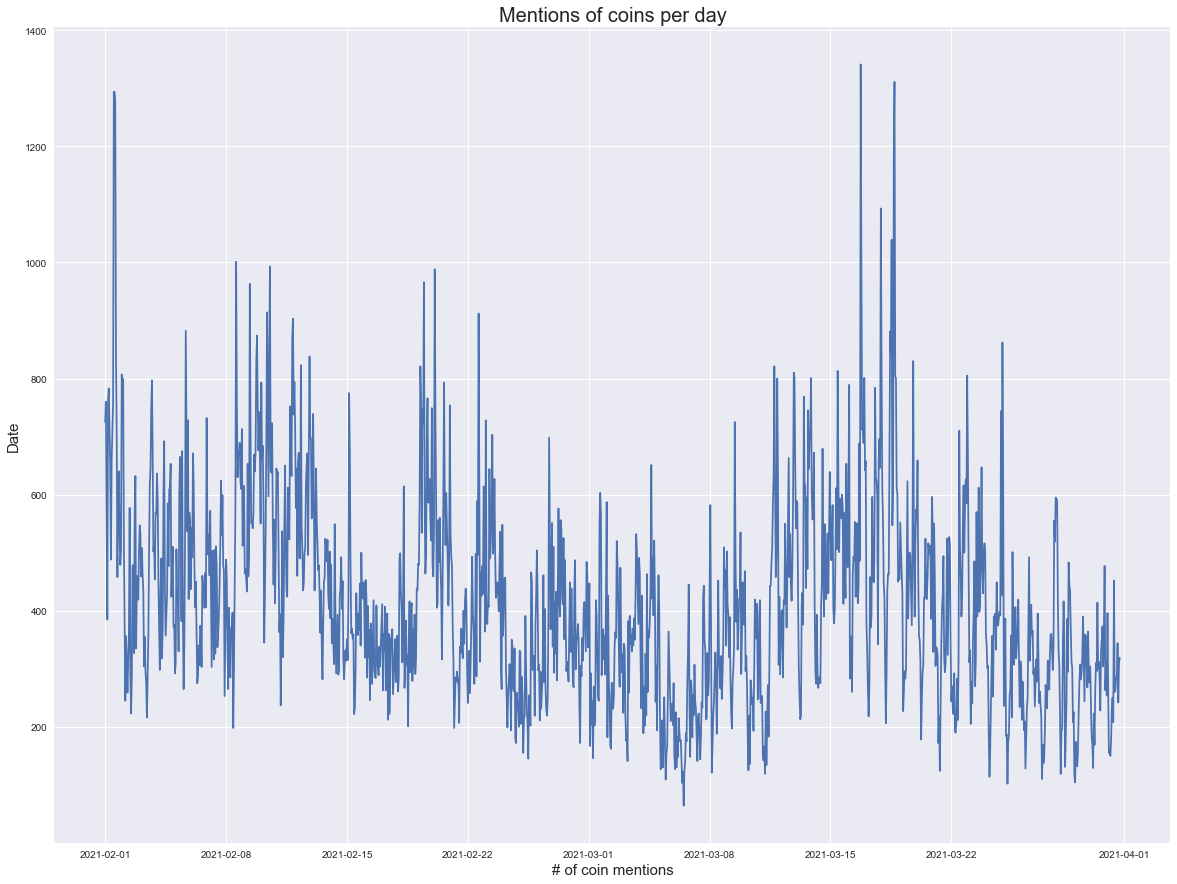

In [63]:
from datetime import datetime
import matplotlib.dates as md
count_all = pd.read_csv(os.path.join(BASE_PATH, "data", "date_count_all.csv"))

dates=[datetime.fromtimestamp(ts) for ts in count_all["date"][0:1410]]
fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(dates,count_all["count"][0:1410])
ax.set_title("Mentions of coins per day", fontsize=TITLE_SIZE)
ax.set_xlabel("# of coin mentions", fontsize=AXES_LABELS_SIZE)
ax.set_ylabel("Date", fontsize=AXES_LABELS_SIZE)
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

plt.show()

### Izvedene analize




In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime
from collections import defaultdict

import os

BASE_PATH = os.path.abspath(os.path.curdir)
PRICE_DATA_DIR = os.path.join(BASE_PATH, "data/price_data/")
MENTIONS_COUNT_DIR = os.path.join(BASE_PATH, "data/date_count")

COLOR_MAIN = "#363A45"
COLOR_MA_5 = "#FF9800"
COLOR_MA_8 = "#E040FB"
COLOR_MA_13 = "#9C27B0"
COLOR_VOLUME = "#B2B5BE"

MIN_DATE = "2021-02-01 00:00:00"
MAX_DATE = "2021-04-05 03:00:00"

TITLE_SIZE = 20
AXES_LABELS_SIZE = 15

DATE_RANGE = pd.date_range(
    start=MIN_DATE,
    end=MAX_DATE,
    freq="2D",
)

plt.style.use("seaborn")

In [32]:
def date_parser(timestamp):
    return datetime.datetime.fromtimestamp(int(timestamp))

Text(0, 0.5, 'Coin')

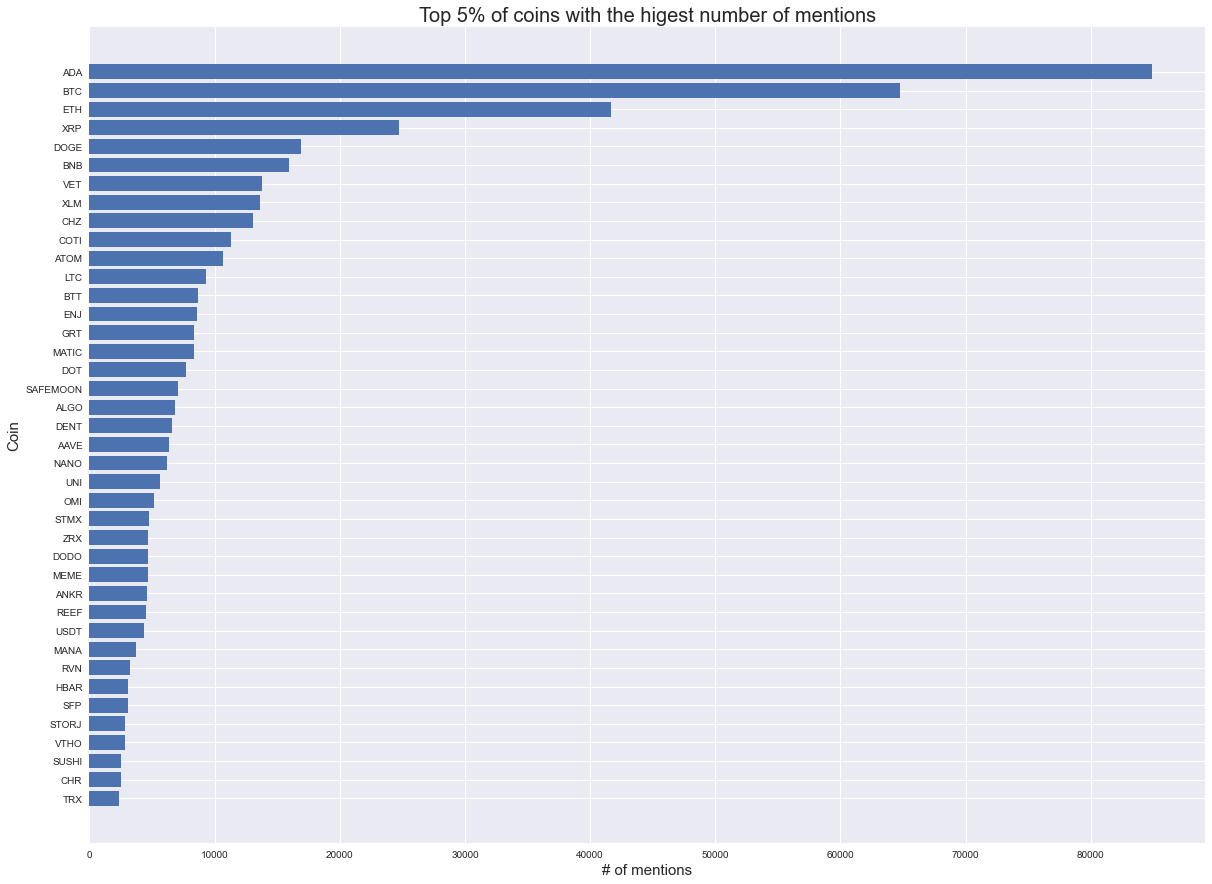

In [33]:
data = pd.read_csv(os.path.join(BASE_PATH, "data", "tracked_coins_details.csv"))
limit = data["count"].quantile(0.95)
data = data[data["count"] >= limit]
data = data.sort_values(by="count")

TRACKED_COINS = data["symbol"].array

fig, ax = plt.subplots(figsize=(20, 15))

ax.barh(data["symbol"], data["count"])
ax.set_title("Top 5% of coins with the higest number of mentions", fontsize=TITLE_SIZE)
ax.set_xlabel("# of mentions", fontsize=AXES_LABELS_SIZE)
ax.set_ylabel("Coin", fontsize=AXES_LABELS_SIZE)

In [37]:
biggest_volume_diff = pd.DataFrame(
    columns=["coin", "min", "min_date", "max", "max_date", "diff", "diff_rel"]
)

for e in os.listdir(PRICE_DATA_DIR):
    if e not in TRACKED_COINS:
        continue

    df = pd.read_csv(os.path.join(PRICE_DATA_DIR, e, f"{e}_volume.csv"))
    min_ = df["volume"].min()
    max_ = df["volume"].max()
    min_date = df[df["volume"] == min_]["date"].array[0]
    max_date = df[df["volume"] == max_]["date"].array[0]
    diff = max_ - min_
    if min_ == 0:
        diff_rel = np.inf
    elif max_date > min_:
        diff_rel = (max_ / min_) - 1
    else:
        diff_rel = -((max_ / min_) - 1)
    biggest_volume_diff = biggest_volume_diff.append(
        {
            "coin": e,
            "min": min_,
            "min_date": min_date,
            "max": max_,
            "max_date": max_date,
            "diff": diff,
            "diff_rel": diff_rel * 100,
        },
        ignore_index=True,
    )
biggest_volume_diff = biggest_volume_diff.sort_values(by="diff_rel", ascending=False)

biggest_price_diff = pd.DataFrame(
    columns=["coin", "min", "min_date", "max", "max_date", "diff", "diff_rel"]
)

for e in os.listdir(PRICE_DATA_DIR):
    if e not in TRACKED_COINS:
        continue

    df = pd.read_csv(os.path.join(PRICE_DATA_DIR, e, f"{e}_price.csv"))
    min_ = df["price"].min()
    max_ = df["price"].max()
    min_date = df[df["price"] == min_]["date"].array[0]
    max_date = df[df["price"] == max_]["date"].array[0]
    diff = max_ - min_
    if min_ == 0:
        diff_rel = np.inf
    elif max_date > min_:
        diff_rel = (max_ / min_) - 1
    else:
        diff_rel = -((max_ / min_) - 1)
    biggest_price_diff = biggest_price_diff.append(
        {
            "coin": e,
            "min": min_,
            "min_date": min_date,
            "max": max_,
            "max_date": max_date,
            "diff": diff,
            "diff_rel": diff_rel * 100,
        },
        ignore_index=True,
    )
biggest_price_diff = biggest_price_diff.sort_values(by="diff_rel", ascending=False)

(24, coin                 OMI
min             0.000036
min_date      1612191600
max             0.013275
max_date      1616198400
diff            0.013239
diff_rel    36622.222545
Name: 24, dtype: object)
(11, coin               DENT
min            0.000337
min_date     1612195200
max            0.018455
max_date     1617573600
diff           0.018118
diff_rel    5381.888341
Name: 11, dtype: object)
(27, coin           SAFEMOON
min                 0.0
min_date     1615752000
max            0.000002
max_date     1617573600
diff           0.000002
diff_rel    4617.862067
Name: 27, dtype: object)
(9, coin                CHZ
min            0.021065
min_date     1612137600
max            0.878633
max_date     1615622400
diff           0.857568
diff_rel    4071.061811
Name: 9, dtype: object)


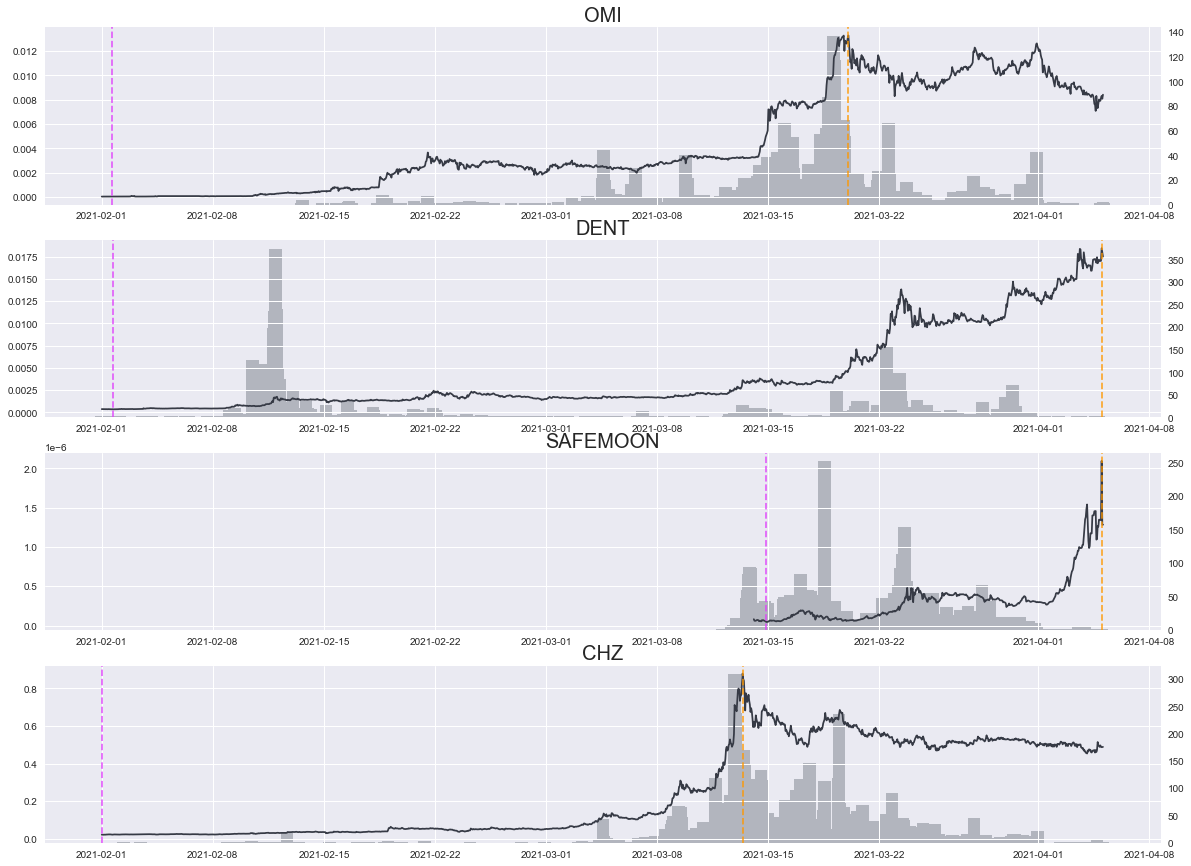

In [35]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))

for i, e in enumerate(biggest_price_diff.iloc[0:4].iterrows()):
    print(e)
    mentions_data = pd.read_csv(
        os.path.join(MENTIONS_COUNT_DIR, f"{e[1]['coin']}.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    price_data = pd.read_csv(
        os.path.join(PRICE_DATA_DIR, e[1]["coin"], f"{e[1]['coin']}_price.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    ax_bar = ax[i].twinx()
    ax_bar.bar(mentions_data.index, mentions_data["count"], color=COLOR_VOLUME)
    ax[i].plot(price_data["price"], color=COLOR_MAIN)

    ax[i].axvline(
        date_parser(e[1]["min_date"]), color=COLOR_MA_8, alpha=0.8, linestyle="--"
    )
    ax[i].axvline(
        date_parser(e[1]["max_date"]), color=COLOR_MA_5, alpha=0.8, linestyle="--"
    )

    ax[i].set_zorder(ax_bar.get_zorder() + 1)
    ax[i].patch.set_visible(False)
    ax[i].set_title(e[1]["coin"], fontsize=TITLE_SIZE)

    ax_bar.patch.set_visible(True)
    ax_bar.grid(b=None)


(24, coin                     OMI
min                61.276314
min_date          1612191600
max         152297926.437139
max_date          1616158800
diff        152297865.160825
diff_rel    248542797.472967
Name: 24, dtype: object)
(27, coin               SAFEMOON
min             1334.996131
min_date         1617573600
max         62307740.426769
max_date         1617526800
diff        62306405.430637
diff_rel     4667159.999189
Name: 27, dtype: object)
(11, coin                     DENT
min            1823765.755047
min_date           1612202400
max         1094191775.771303
max_date           1616511600
diff        1092368010.016256
diff_rel         59896.289148
Name: 11, dtype: object)
(8, coin                      CHR
min            3415818.122391
min_date           1614416400
max         1939329862.291929
max_date           1615546800
diff        1935914044.169538
diff_rel         56674.974334
Name: 8, dtype: object)


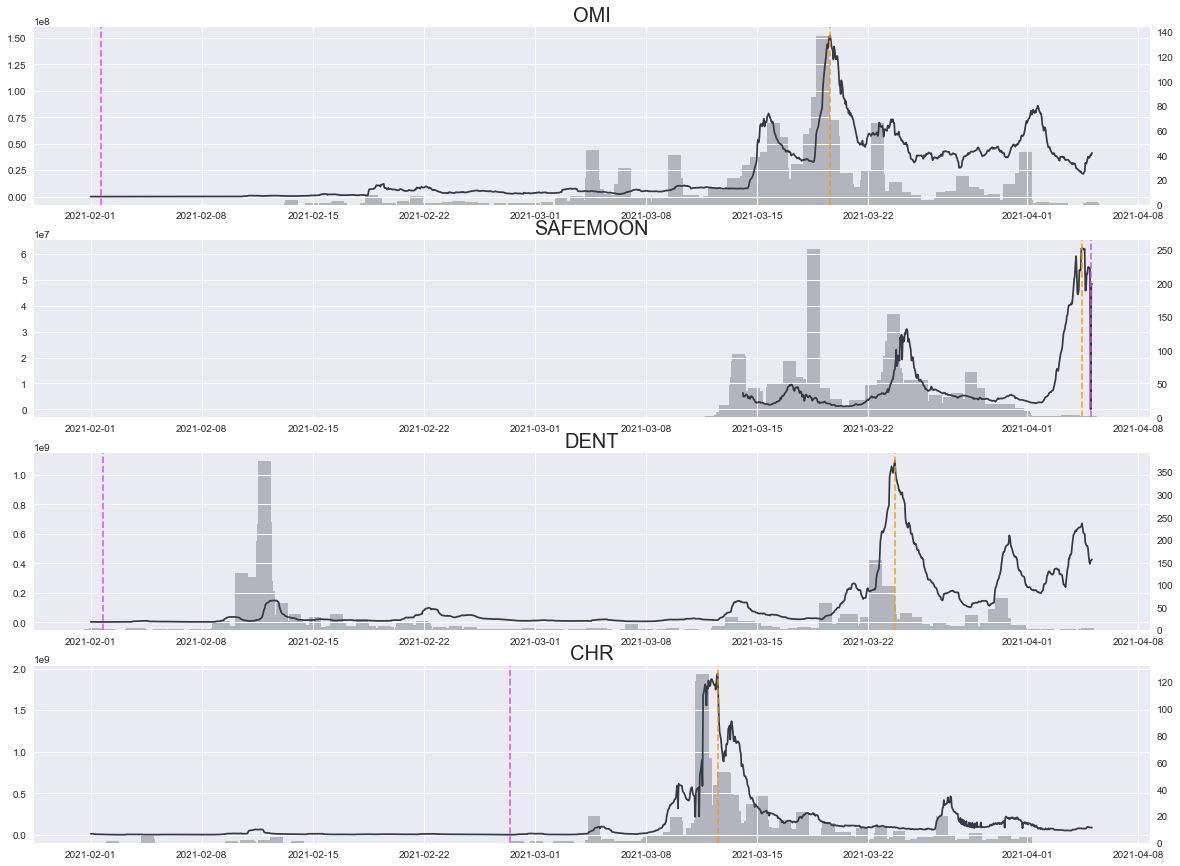

In [36]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))

for i, e in enumerate(
    biggest_volume_diff[biggest_volume_diff["max"] != 0].iloc[0:4].iterrows()
):
    print(e)
    mentions_data = pd.read_csv(
        os.path.join(MENTIONS_COUNT_DIR, f"{e[1]['coin']}.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    volume_data = pd.read_csv(
        os.path.join(PRICE_DATA_DIR, e[1]["coin"], f"{e[1]['coin']}_volume.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    ax_bar = ax[i].twinx()
    ax_bar.bar(mentions_data.index, mentions_data["count"], color=COLOR_VOLUME)
    ax[i].plot(volume_data["volume"], color=COLOR_MAIN)

    ax[i].axvline(
        date_parser(e[1]["min_date"]), color=COLOR_MA_8, alpha=0.8, linestyle="--"
    )
    ax[i].axvline(
        date_parser(e[1]["max_date"]), color=COLOR_MA_5, alpha=0.8, linestyle="--"
    )

    ax[i].set_zorder(ax_bar.get_zorder() + 1)
    ax[i].patch.set_visible(False)
    ax[i].set_title(e[1]["coin"], fontsize=TITLE_SIZE)

    ax_bar.patch.set_visible(True)
    ax_bar.grid(b=None)

### Glavne ugotovitve

Trenutno smo še osredotočeni na pridobivanje čim več kvalitetnih podatkov, ki bodo v nadaljevanju osnova za uspešno iskanje odgovorov v podatkih.
